# Bottleneck Simulated Annealing

In [1]:
import numpy as np
import scipy.spatial
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Generate some data

In [2]:
NUM_POINTS = 100
NUM_FEATURES = 12

### Generate points

In [3]:
points = np.random.rand(NUM_POINTS, NUM_FEATURES)

### Compute pairwise distances

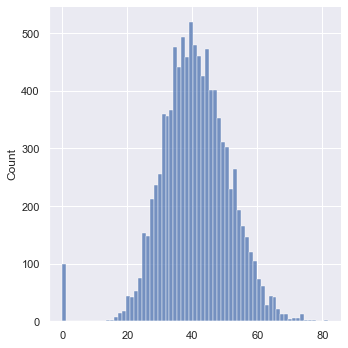

In [4]:
NORM_P = 0.5
distance_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(points, "minkowski", p=NORM_P))
sns.displot(distance_matrix.flatten())

### Experiment: Determining a good distance metric for various dimensionalities

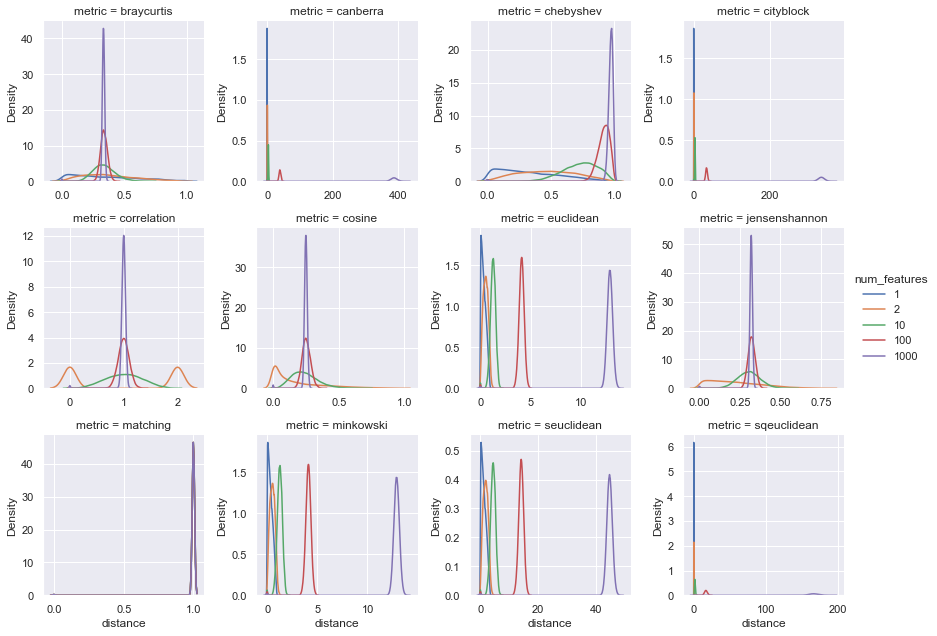

In [19]:
import itertools
import pandas as pd

num_points = 200
num_features_space = [1, 2, 10, 100, 1000]
points_map = {num_features: np.random.rand(num_points, num_features) for num_features in num_features_space}

distance_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'jensenshannon', 'matching', 'minkowski', 'seuclidean', 'sqeuclidean']
distances = pd.DataFrame([
    {
        "num_features": num_features,
        "metric": distance_metric,
        "distance": distance
    }
    for (num_features, points), distance_metric in itertools.product(points_map.items(), distance_metrics)
    for distance in scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(points, distance_metric)).flatten()
])
grid = sns.FacetGrid((distances), hue="num_features", col="metric", col_wrap=4, sharex=False, sharey=False)
grid.map(sns.kdeplot, "distance", warn_singular=False)
grid.add_legend()

## Compute the best path through the points

### Define the objective

In [5]:
from simanneal import Annealer

rng = np.random.default_rng()

class BottleneckAnnealer(Annealer):
    copy_strategy = "method"  # Use `self.state.copy()` to copy the state
    
    # Override default hyperparameters
    Tmin = 1e-6
    Tmax = 1e3
    steps = 500000
    updates = 500

    def __init__(self, *args, path: np.ndarray, distance_matrix: np.ndarray, **kwargs):
        super().__init__(path, *args, **kwargs)
        self.distance_matrix = distance_matrix
        self.num_points = len(self.state)

    def move(self):
        """
        Randomly swap points
        """
        num_swaps = int(np.random.rand() * 4)
        swaps = rng.choice(self.num_points, (num_swaps, 2), replace=False)
        self.state[swaps] = self.state[swaps[..., ::-1]]

    def energy(self):
        """
        Compute the energy of the current path
        """
        # Find the length of the edge from each node in the path to the next
        source_nodes = self.state
        target_nodes = np.roll(source_nodes, 1)
        edge_distances = self.distance_matrix[source_nodes, target_nodes]
        max_edge_length = edge_distances.max()
        mean_edge_length = edge_distances.mean()
        energy = max_edge_length + mean_edge_length
        return energy

### Initialize the annealer

In [6]:
annealer = BottleneckAnnealer(path=np.arange(len(points)), distance_matrix=distance_matrix)
print(f"Start energy: {annealer.energy()}")

Start energy: 104.22151230927489


### Optimize

In [7]:
best_path, best_energy = annealer.anneal()
print(f"Best energy: {best_energy}")
print(best_path)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000         62.29    24.70%     0.00%     0:00:28     0:00:00

Best energy: 62.29454667899347
[36 15 99 13 42 16 71  9 37 75 62  3  5 46 76 18 41 93 96 23 29 65 82 25
 61 68 87 38 28 67 32 77  2 43 90 51 12 84  7 89 44 81 40 27 48 94 79 20
 97 66 57 86 30 56 50 14 88  4 85 55  8 59 70 47 64 58 35 21 10  1 54 78
 92 26 73 33 31 17 22 45 74 63 91  0 49 34  6 53 19 39 60 95 69 98 72 24
 83 11 52 80]


In [9]:
annealer.auto(1/60, steps=1000000)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00073         58.44    25.00%     0.00%     0:27:58    -1:32:28

{'tmax': 21.0, 'tmin': 0.00073, 'steps': 20000, 'updates': 500}